In [1]:
pip install --upgrade yfinance==0.2.54

In [2]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.1 MB/s eta 0:00:00


In [3]:
pip install scikit-learn

In [4]:
pip install pandas_datareader

In [5]:
pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 19.7 MB/s eta 0:00:00


In [1]:
import yfinance as yf
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm  # for CAPM and Fama-French regressions
import pandas_datareader
import matplotlib.pyplot as plt
from arch import arch_model
import itertools
from pypfopt import EfficientFrontier, risk_models, expected_returns, EfficientCVaR, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import cvxpy as cp

In [2]:
def garch_aic_sel(returns):
    # Define grids for model parameters
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']

    results = []

    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0

                # -----------------------------
                # Fit the full model on the dataset
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')

                # -----------------------------
                # Get the AIC from the model
                aic = res.aic
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})

    # Find the best model based on AIC
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

In [ ]:
#Combined Code

# ----------------------------
# 1. Load Fama–French Factor Data
# ----------------------------
ff = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# Date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
ff = ff.set_index('Date')
# Convert factor returns from percentages to decimals
ff = ff.astype(float) / 100

# ----------------------------
# 2. Forecast Factors using optimal GARCH(1,1) on 100x Scaled Data
# ----------------------------
forecast_results = {}
factors = ['Mkt-RF', 'SMB', 'HML']

for factor in factors:
    series_ = ff[factor].dropna()
    # convert to log-returns
    series = np.log(1 + series_)
    # Scale the series by 100 to stabilize the GARCH estimation
    mean, vol, dist = garch_aic_sel(100 * series)
    am = arch_model(100 * series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')

    # Forecast one period ahead (next month)
    forecast = res.forecast(horizon=1, reindex=False)

    # The forecasted mean is on a 100x scale and variance on a 100^2 scale.
    next_step_mean_ = forecast.mean.iloc[-1, 0]/100
    next_step_variance_ = forecast.variance.iloc[-1, 0]/100**2

    # convert the forecasted mean and variance to the mean and variance of the simple returns, using the log-normal transformation
    next_step_mean = np.exp(next_step_mean_ + next_step_variance_ / 2) - 1
    next_step_variance = (np.exp(next_step_variance_ ) - 1) * (np.exp(2 * next_step_mean_  + next_step_variance_ ))

    forecast_results[factor] = {'next_step_mean': next_step_mean,
                                'next_step_variance': next_step_variance}
    print(f"Forecast for {factor} (next period): Mean = {next_step_mean}, Variance = {next_step_variance}")

# ----------------------------
# 3. Download Stock Data and Run Regressions
# ----------------------------
start_date = '2009-12-31'
end_date = '2023-12-31'
tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
prices = yf.download(tickers, start=start_date, end=end_date, interval='1mo', auto_adjust=True)['Close']
prices_test = yf.download(tickers, start=end_date, end='2024-12-31', interval='1mo', auto_adjust=True)['Close']

returns = prices.pct_change().dropna()

# Align dates of stock returns and factor data
common_dates = returns.index.intersection(ff.index)

# Check if common_dates is empty and handle accordingly
if len(common_dates) == 0:
    print("Error: No common dates found between stock returns and Fama-French data.")
    # Further investigation and data adjustment are needed
else:
    returns = returns.loc[common_dates]
    ff = ff.loc[common_dates]


# Run OLS regressions to estimate factor loadings and obtain residual variances.
results = {}   # to store regression outputs
coeffs = {}    # to store estimated coefficients for each ticker

for ticker in tickers:
    df = pd.DataFrame({'r': returns[ticker]})
    df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
    # Compute excess returns: r - RF
    df['excess'] = df['r'] - df['RF']

    # Independent variables are the three factors (with constant)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess']

    model = sm.OLS(y, X).fit()
    results[ticker] = model
    coeffs[ticker] = {
         'alpha': model.params['const'],
         'Mkt-RF': model.params['Mkt-RF'],
         'SMB': model.params['SMB'],
         'HML': model.params['HML']
    }

    print(f"\nRegression results for {ticker}:\n", model.summary())

# ----------------------------
# 4. Forecast Next Step Expected Returns (r_{i,t+1})
# ----------------------------
forecast_r = {}
for ticker in tickers:
    alpha = coeffs[ticker]['alpha']
    r_forecast = alpha
    for factor in factors:
        beta = coeffs[ticker][factor]
        factor_mean = forecast_results[factor]['next_step_mean']
        r_forecast += beta * factor_mean
    forecast_r[ticker] = r_forecast
    print(f"\nForecasted r_{ticker}, t+1: {r_forecast}")

# ----------------------------
# 5. Calculate Total Forecast Error Variance for r_{i,t+1}
# ----------------------------
# Total variance = sum_j (beta_{ij}^2 * (sigma_{j, forecast}^2 / 100^2)) + sigma^2_reg,
# where sigma^2_reg is the mean squared error (residual variance) from the regression.
forecast_error = {}
for ticker in tickers:
    beta_squared_sum = 0
    for factor in factors:
        beta = coeffs[ticker][factor]
        factor_variance = forecast_results[factor]['next_step_variance']
        beta_squared_sum += (beta**2) * factor_variance

    sigma2_reg = results[ticker].mse_resid  # regression residual variance
    total_variance = beta_squared_sum + sigma2_reg
    forecast_error[ticker] = total_variance
    print(f"Total forecast error variance for {ticker}: {total_variance}")


Forecast for Mkt-RF (next period): Mean = 0.01016400289991215, Variance = 0.0016505269945385483
Forecast for SMB (next period): Mean = 0.0006864029404214378, Variance = 0.0011731800077627638


[*********************100%***********************]  8 of 8 completed
[**********************50%                       ]  4 of 8 completed

Forecast for HML (next period): Mean = 0.0023962797673686698, Variance = 0.0008347280333907814


[*********************100%***********************]  8 of 8 completed



Regression results for AAPL:
                             OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     45.98
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           1.38e-21
Time:                        15:19:58   Log-Likelihood:                 239.99
No. Observations:                 167   AIC:                            -472.0
Df Residuals:                     163   BIC:                            -459.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099

In [74]:
annualizer = 12

annualized_return = {ticker: forecast_r[ticker] * annualizer for ticker in tickers}
annualized_error = {ticker: np.sqrt(forecast_error[ticker]) * np.sqrt(annualizer) for ticker in tickers}


In [ ]:
from pypfopt import EfficientFrontier, risk_models

def mvar_lognormal_transform(mu, sigma, horizon=1):
    """
    Transform the mean mu and covariance sigma of single-period log-returns to the mean and covariance of multi-period simple returns.
    horizon sets the number of periods over which the multi-period returns are calculated.
    """

    # apply the square-root law to the moments of the log-returns
    mu *= horizon
    sigma *= horizon

    # calculate the mean and covariance of the log-normal distributed simple returns at the horizon
    mu_ln = np.exp(mu + np.diagonal(sigma) / 2)

    outerprod = np.outer(mu_ln, mu_ln)

    sigma_ln = outerprod * (np.exp(sigma) - 1)
    return mu_ln - 1, sigma_ln



# calculate the optimal max sharpe portfolio using the forecasted mean return as expected returns and the empirical covariance for risk
# make sure you use log-returns to use their time additivity and then convert to simple returns for their cross-sectional additivity
mu_ = np.log(1 + pd.Series(forecast_r))
S_ = risk_models.sample_cov(prices, frequency=1, log_returns=True)

mu, S_train = mvar_lognormal_transform(mu_, S_, horizon=12)

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 23.3%
Annual volatility: 15.7%
Sharpe Ratio: 1.48


(np.float64(0.23290714174936286),
 np.float64(0.15709977172401282),
 np.float64(1.4825428400909817))

<Axes: >

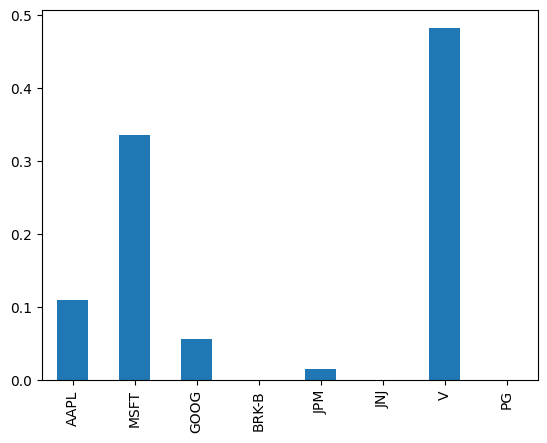

In [76]:
# plot the weights of the optimal portfolio
weights = pd.Series(weights)
weights.plot(kind='bar')


In [77]:
weights*100

AAPL     11.027180
MSFT     33.551104
GOOG      5.635993
BRK-B     0.000000
JPM       1.547060
JNJ       0.000000
V        48.238664
PG        0.000000
dtype: float64

In [78]:
viewdict = {t:annualized_return[t] for t in tickers}
viewdict

{'AAPL': np.float64(0.24640195841637003),
 'MSFT': np.float64(0.19477497066329202),
 'GOOG': np.float64(0.16652688751485228),
 'BRK-B': np.float64(0.11773450707307034),
 'JPM': np.float64(0.18655499193900396),
 'JNJ': np.float64(0.0937891737226168),
 'V': np.float64(0.1864383060022479),
 'PG': np.float64(0.08795464589276049)}

In [81]:
view_omega = np.diag([annualized_error[t] for t in tickers])
view_omega

array([[0.27295596, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.23152194, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25268003, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.17408335, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.23254863,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.162153  , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.2076462 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1665182 ]])

In [83]:
sp500 = yf.download("^GSPC", start="2009-12-31", end="2024-12-31", interval='1mo', auto_adjust=True)['Close']
sp500_returns = sp500.pct_change().dropna()

delta = black_litterman.market_implied_risk_aversion(sp500, frequency=annualizer, risk_free_rate=0.05/annualizer)
mcaps = {ticker:yf.Ticker(ticker).info['marketCap'] for ticker in tickers}

prior = black_litterman.market_implied_prior_returns(mcaps, delta, S_train)
print("Market-implied prior:")
print(prior)

bl = BlackLittermanModel(S_train, pi = prior, absolute_views=viewdict, omega=view_omega)
mu_train = bl.bl_returns()
print("B-L expected returns:")
print(mu_train)

[*********************100%***********************]  1 of 1 completed

Market-implied prior:
Ticker
AAPL     0.376104
BRK-B    0.133755
GOOG     0.267575
JNJ      0.090165
JPM      0.218381
MSFT     0.234568
PG       0.081098
V        0.172284
dtype: float64
B-L expected returns:
Ticker
AAPL     0.371737
BRK-B    0.132390
GOOG     0.264272
JNJ      0.089385
JPM      0.215901
MSFT     0.232127
PG       0.080415
V        0.170607
dtype: float64


Optimized Weights:
OrderedDict({'AAPL': 0.30258, 'BRK-B': 0.09017, 'GOOG': 0.17644, 'JNJ': 0.03474, 'JPM': 0.05683, 'MSFT': 0.24624, 'PG': 0.03604, 'V': 0.05695})


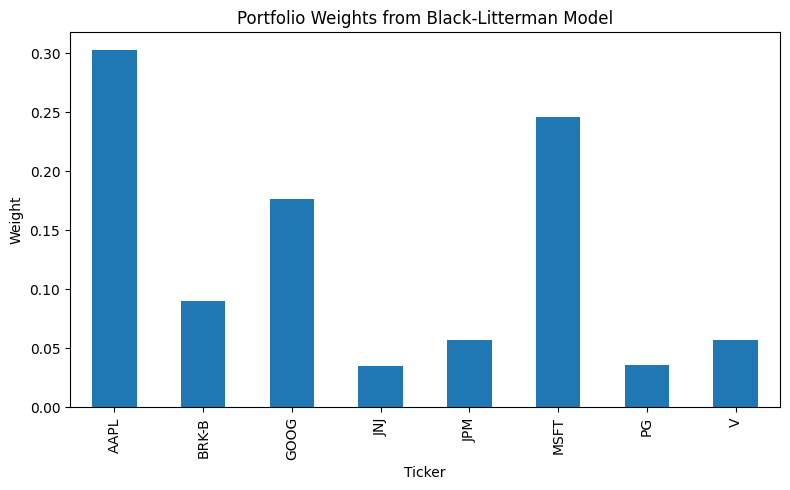

Expected annual return: 25.6%
Annual volatility: 21.3%
Sharpe Ratio: 1.20


In [84]:
ef_bl = EfficientFrontier(mu_train, S_train)
weights_bl = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print("Optimized Weights:")
print(cleaned_weights_bl)

# Plot the portfolio weights
weights_series = pd.Series(cleaned_weights_bl)
weights_series.plot(kind="bar", figsize=(8, 5))
plt.title("Portfolio Weights from Black-Litterman Model")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# Optionally, display the portfolio performance metrics
performance = ef_bl.portfolio_performance(verbose=True)

Optimized Weights:
OrderedDict({'AAPL': 0.30377, 'BRK-B': 0.09006, 'GOOG': 0.17818, 'JNJ': 0.03418, 'JPM': 0.0574, 'MSFT': 0.24535, 'PG': 0.0353, 'V': 0.05575})


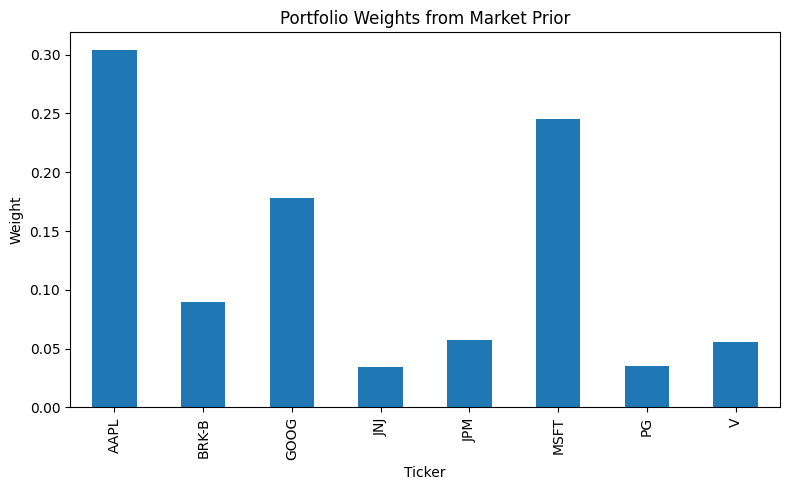

Expected annual return: 26.0%
Annual volatility: 21.3%
Sharpe Ratio: 1.22


In [85]:
ef_mkt =  EfficientFrontier(prior, S_train)
weights_mkt = ef_mkt.max_sharpe()
cleaned_weights_mkt = ef_mkt.clean_weights()
print("Optimized Weights:")
print(cleaned_weights_mkt)

# Plot the portfolio weights
weights_series_mkt = pd.Series(cleaned_weights_mkt)
weights_series_mkt.plot(kind="bar", figsize=(8, 5))
plt.title("Portfolio Weights from Market Prior")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# Optionally, display the portfolio performance metrics
performance_mkt = ef_mkt.portfolio_performance(verbose=True)

In [ ]:
# test all portfolios out of sample
def compute_out_of_sample_return(weights, test_data, annualizer=252):
    """
    Given a weights dictionary and test period price data, compute the realized
    annualized portfolio return.
    """
    # Convert weights dictionary to a Series (for proper alignment)
    weights_series = pd.Series(weights)
    # Compute daily returns for the test period.
    test_returns = test_data.pct_change().dropna()
    # Calculate the portfolio's daily return (aligned by tickers)
    portfolio_daily_returns = (test_returns * weights_series).sum(axis=1)
    # Annualize the return (assume 252 trading days)
    realized_return = (1 + portfolio_daily_returns).prod() ** (annualizer / len(portfolio_daily_returns)) - 1
    return realized_return


# Compute the out-of-sample return for the forecast-based portfolio
oos_return = compute_out_of_sample_return(weights, prices_test, annualizer)
print(f"Out-of-sample return for forecast-based portfolio: {oos_return}")

# Compute the out-of-sample return for the Black-Litterman portfolio
oos_return_bl = compute_out_of_sample_return(cleaned_weights_bl, prices_test, annualizer)
print(f"Out-of-sample return for Black-Litterman portfolio: {oos_return_bl}")

# Compute the out-of-sample return for the Market Prior portfolio
oos_return_mkt = compute_out_of_sample_return(cleaned_weights_mkt, prices_test, annualizer)
print(f"Out-of-sample return for Market portfolio: {oos_return_mkt}")


Out-of-sample return for forecast-based portfolio: 0.19001423766196535
Out-of-sample return for Black-Litterman portfolio: 0.2679996404167684
Out-of-sample return for Market portfolio: 0.2691143094366628
